#  Hypothesis testing, simple case

*Author: Jose A. Hernando, X. Cid Vidal*, February 2025

*Instituto Galego de Altas Enerxías. Universidade de Santiago de Compostela, Spain.*

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/xabiercidvidal/USC-TA/master)

In [1]:
import time
print( ' Last Execution ', time.asctime())

 Last Execution  Wed Jan 28 15:04:10 2026


In [2]:
# general imports
%matplotlib inline
%reload_ext autoreload
%autoreload 2
 
# numpy and matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

import httoys    as httoys
import htcore    as htcore
import htcatalog as htcata
import htplot    as htplot

plt.style.context('seaborn-colorblind');

## Introduction


The simple hypothesis testing involves a null hypothesis $H_0$ (i.e the SM) and an alternative hypothesis $H_1$ (i.e BSM Physics).

Given a dataset, $x$, which of both hypotheses agrees better with data? 

Can we exclude $H_1$? At what level? 

Can we claim an *observation* or a *discovery* of New Physics?

We will try to solve these questions in this lecture.

Look at the following simple example, $H_0, H_1$ are both gaussians with sigma one, $H_0$ has mean zero and $H_1$ has mean $\mu$. 

Given an observation, $x_0$, data agrees more with $H_0$ or with $H_1$?

*Explore* In the next Python cell, execute few events, see where the data, $x_0$, falls along the axis. Move the gaussians appart, change their widths.

(Forget for the moment the printed values, except for the observed data)

observed data : [1.10122519]
H0 p-value    : 0.13539933
H1 p-value    : 0.00004834
CLs           : 0.00005591 


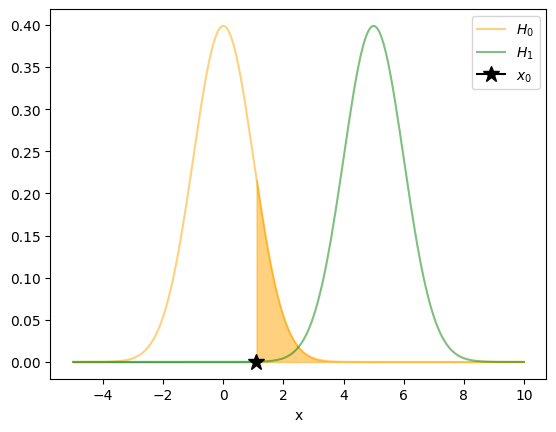

In [3]:
mu0, mu1, mutrue = 0, 5, False
httoys.gaussian(mu0, mu1, mutrue = mutrue);

The $x$ axis in this case allows us to quantify the "distance" between hypotheses. To the left it is more $H_0$-like, to the right more $H_1$-like.

**Questions**:    
- $H_0$ is on the left. There is a colored area behind the curve of $H_0$ and on the right of the data, $x_0$. What does that area correspond to?
    
- $H_1$ is on the right. There is a colored area behind the curve of $H_1$ and on the left of the data, $x_0$. Now, what does that area correspond to?

## Test statistics

We need to **order** data, $x$, along the axis from $H_0$ to $H_1$, to the left it is more $H_0$-like, to the right, more $H_1$-like.

<table style="border: 1px solid black; border-collapse: collapse;">
    <tr>
        <td style="border: 1px solid black; padding: 8px;font-size: 14px;">The <b>test statistics</b>, $q(x)$, is a real scalar quantity that quantifies how compatible is our data, $x$, with the null, $H_0$, and the alternative, $H_1$, hypotheses.</td>
    </tr>
</table>




As a convention, we consider that as $q(x)$ values increase, they indicate a better agreement with $H_1$ than with $H_0$. 


The *optimal* test-stats is the likelihood ratio.

For convenience we use (-2 log-like-ratio):

$$
q(x) = -2 \log \, \frac{ \mathcal{L}(x \, | \, H_0)}{ \mathcal{L}(x \, | \, H_1)}
$$



optimal: better efficiciency for $H_1$ for the same fraction of $H_0$ contamination (see later).

*Note*: In many cases, we do not know how to compute $q(x)$ and then we use *multivariate methods* as **Neural Networks** (NN) or **Boosted Decision Trees** (BDTs). They provide a test-statistics!

Now, we need to compute the pdf of $q$ for both hypotheses, $g(q| H_0)$ and $g(q | H_1)$.

In some cases we can do it analytically, but in others it is almost impossible.

Nevertheless, we can do **simulations** and compute the $q$ values and obtain its distribution for *all possible events* of the $H_0$ type, $\{ x \}_0$, and $H_1$, $\{ x \}_1$. 



### Gaussian pdf as an example

**Example:** Consider as $H_0$ a gaussian distribution with mean $\mu_0$ and $\sigma_0$;
and $H_1$ again a gaussian distribution with $\mu_1$ and $\sigma_1$. Obtain the pdfs,  $g(q |H_0)$ and $g(q|H_1)$ for $\mu_0 = 0, \, \sigma_0 = 1, \, \mu_1 = 4, \, \sigma_1 = 2$. 


In [4]:
def two_gaussian(mu0, sigma0, mu1, sigma1, size = 10000):

    # the test-statistics function: note we're doing log(exp(-(x-mu)**2/(2*sigma**2)))
    def q(x, m1=mu1, s1=sigma1, m0=mu0, s0=sigma0):
        return (x-m0)*(x-m0)/(s0*s0) - (x-m1)*(x-m1)/(s1*s1)

    # hypotheses
    h0 = stats.norm(mu0, sigma0)
    h1 = stats.norm(mu1, sigma1)

    # m-experiments for both hypotheses
    x0s = h0.rvs(size = int(size))
    x1s = h1.rvs(size = int(size))

    # the q-values for the m-experiments of both hypotheses
    q0s = q(x0s) 
    q1s = q(x1s)

    return q0s, q1s

In [5]:
def plt_test_stats(q0s, q1s, bins = 100, range = None):
    range = (np.min(q0s), np.max(q1s)) if range is None else range
    plt.hist(q0s, bins, density = True, range = range, color = 'blue', 
             alpha = 0.8, label = '$q(x|H_0)$', histtype = 'step');
    plt.hist(q1s, bins, density = True, range = range, color = 'red' , 
             alpha = 0.8, label = '$q(x|H_1)$', histtype = 'step');
    plt.xlabel('$q(x)$'); plt.ylabel('$g(q|x)$')
    plt.legend(); 

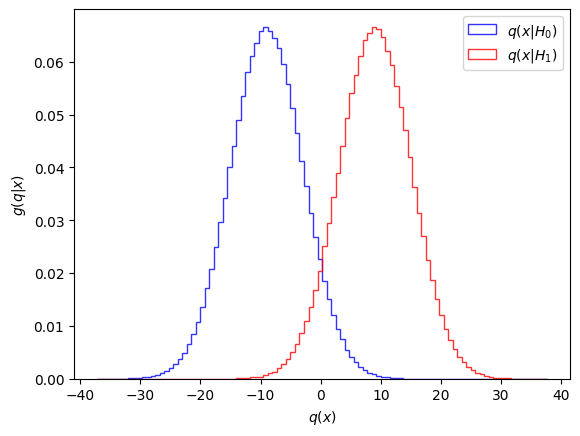

In [6]:
q0s, q1s = two_gaussian(0., 1., 3., 1., size = 1e6)
plt_test_stats(q0s, q1s);

**Question:** Consider that we measure $q(x) = -10$, what can you say about $H_1$? And if we measure $q(x) = 30$?


**Question:** Discuss what happens when the distributions overlap and when they do not.


### A counting experiment

Experiments are sometimes called **counting experiments**, they search for a signal, expecting a given number of events $s$, over a background level, $b$. This is a first approximation for a Rare Event Search.

The distribution of the data follows a poisson distribution with mean, $b$, in case only background is present; and a poission distribution with mean $b+s$ in the presence of signal.

**Explore** in the following cell how the distributions change with $b$ and $s$, and how the result of the experiment changes depending on $data$.

observed data : 11
H0 p-value    : 0.00029234
H1 p-value    : 0.69677615
CLs           : 0.69682589 


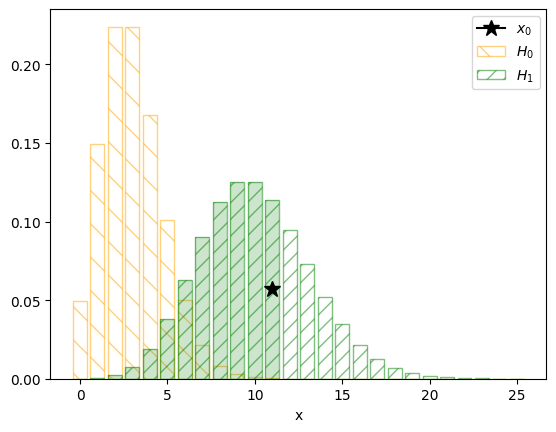

In [7]:
mu0, mu1, mutrue = 3, 10., True
httoys.poisson(mu0, mu1, mutrue = mutrue);

**Class exercise**: Consider now a poisson distribution with $\mu_0 = b$ for $H_0$ and  another poisson distribution with $\mu_1 = b + s$ for $H_1$, consider $b=3, s=2$. Obtain the pdfs of the test-statistics, $g(q| H_0), \; g(q | H_1)$.

**Exercise**:
Consider a **hypothetical search for a new particle** at the **LHC**. Assume we are looking for a **new resonance (X) decaying into two photons ($\gamma\gamma$)** in a **100 fb$^{-1}$** dataset at **$(\sqrt{s} = 13$) TeV**. 
**Determine**
- **Signal Yield**: The predicted cross-section for $( pp \to X \to \gamma\gamma $) is **1 fb**, and the detector **acceptance times efficiency** is **50%**. Compute the expected number of signal events.
- **Background Yield**: The main background comes from the **Standard Model diphoton production**, with a **background index of $(5 \times 10^{-3}$) events/(GeV fb$^{-1}$)** at **125 GeV**. Assume an **energy resolution of 1%** at 125 GeV and define the **Region of Interest (RoI) as $(\pm 3\sigma$)**. Compute the expected number of background events.
- **Test Statistics PDFs**: Assume that the **signal is normally distributed**. Compute the **expected distributions of the test statistics** under the **signal-plus-background (S+B)** and **background-only (B) hypotheses**.

Analyze how changing the cross-section, background index or energy resolution affect the **signal-to-background ratio** and the **test statistics distributions**.

### N-poisson case

Another case very common is a n-bin counting experiment. For example the first $B_s \to \mu^+ \mu^-$ very rare [decay search](https://arxiv.org/pdf/1110.2411) at LHCb. In every bin there is an expectation for the background and for the signal. If the bins are independent, each one is like a single-counting experiment.

**Explore**: In the following cell we are simulating one event for a n-bin counting experiment. Play with the background and the signal, and the number of bins.


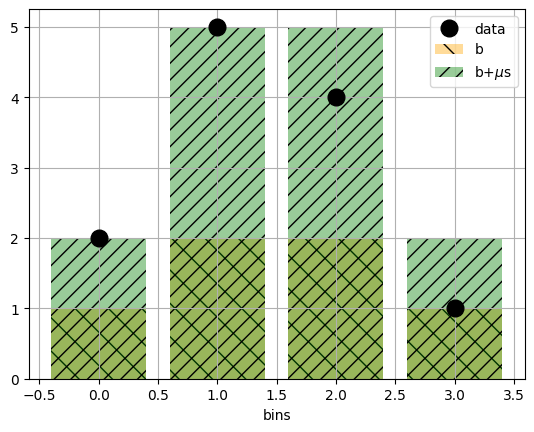

In [8]:
b, s = [1., 2., 2., 1.], [1, 3, 3, 1]
httoys.npoisson_rvs(b, s)

**Class exercise**: Consider a counting experiment with four independent bins. The background for $H_0$ is poisson distributed in each bin with ${\bf b} = (2, 1.5, 1, 0.5)$ and $H_1$ a signal, is also poisson distributed on top of the background ${\bf b} + {\bf s}$ with ${\bf s} = (1, 3, 3, 1)$. Obtain the pdfs of the test-statistics $g(q|H_0), \; g(q |H_1)$. 

Tip: simulate many experiments for each hypothesis and obtain the pdfs of the test-statistics, $g(q|H_0), \, g(q|H_1)$.

*Guide*:
    
  * Consider a single-counting experiment, with background $b$, expected signal $s$, and observed number of events $n$
    
$$
-2 \log \frac{\mathcal{L}(n | b)}{\mathcal{L}(n | b + s)} = 2 n \,( \, \log(b + s) - \log(b) \,)
$$
    
   * Consider a m-bins-counting experiment, with background ${\bf b} = (b_1, \dots, b_m)$, expected signal ${\bf s} = (s_1, \dots, s_m)$, and observed number of events in each bin, ${\bf n} = (n_1, \dots, n_m)$
    
$$
-2 \log \frac{\mathcal{L}({\bf n} | {\bf b})}{\mathcal{L}({\bf n} | {\bf b} + {\bf s})} = 2 \sum_i^m n_i \,( \, \log(b_i + s_i) - \log(b_i) \,)
$$



**Exercise**: Consider the expected background events and signal events in bins of energy in the RoI of the KamLAND-Zen experiment in Fig 2-b) [PRL-117](https://arxiv.org/abs/1605.02889). And compute now the pdfs of $q$ for only background and 10 times the signal.


*Guide:* 

From Fig 2-b) Period II we can extract the following number of background, signal and observed events.

*b* = [4.0, 2.0, 1.6, 1.0, 0.8, 0.7, 0.6, 0.5, 0.5, 0.5, 0.6, 0.6, 0.8, 1.1]

*s* = [0.2, 0.4, 0.5, 0.6, 0.5, 0.4, 0.2, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0]

*x* = [4.0, 0.0, 2.0, 4.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 0.0]

## Significance and power


We can classify events into $H_0$ or $H_1$ hypotheses using a threshold, $k$, on the test statistics:

$$
q(x) < k
$$

An observed data instance, $x_0$, with a test-statistics, $q_0 = q(x_0)$, is classified as $H_0$ if $q_0  < k $ and as $H_1$ if $q_0 \ge k$. This is known as the Neyman's approach. 

What is the value of $k$? It depends on the case: it is not the same to separate $b/c$ jets than to search for a new SUSY particle or a Majorana neutrino!



We define the **significance**, also called *size of the test*, $\alpha$: 

$$
\alpha = \int_{k}^{\infty} g(q({\bf x}) \, | \, H_0) \, \mathrm{d}x
$$

the significance, $\alpha$, is also called *error of 1st kind* and **p-value** of $H_0$. It is the probability to claim $H_1$ when in reality $H_0$ is the right hypothesis. The *false positive* or *contamination*!


The **p-value** is the probability that we get an event with equal or less *compatibility with a given hypothesis* than for the observed data. To get an event as *extreme or more extreme* than the one observed.


Finally,

$$
\beta = \int_{-\infty}^{k} g( q({\bf x}) \, | \, H_1) \, \mathrm{d}x
$$

It is the *error of 2nd kind* or the **p-value of $H_1$**. 

The **power** of the test (or efficiency) is $1-\beta$, the fraction of events classified as $H_1$ when $H_1$ is true. The true positives! The *efficiency*!

The **Neyman-Person lemma** stablishes that the *optimal* test statistics is the **likelihood ratio**. Optimal indicates that we obtain the maximum power (efficiency) for a fixed significance (contamination) of the test. 

**Example** In the case of the two gaussians, the p-values, $\alpha$, $\beta$, are the integrals of the colored areas.

observed data : [-0.58352369]
H0 p-value    : 0.72022959
H1 p-value    : 0.00016950
CLs           : 0.00060584 


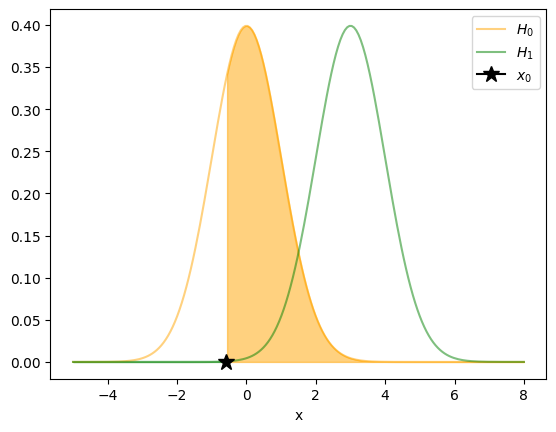

In [9]:
mu0, mu, mutrue = 0, 3, False
httoys.gaussian(mu0, mu, mutrue = mutrue);

We call the RoC curve the efficiency (or power or $1 - \beta$), vs rejection (or 1-$\alpha$) of the background. This is usually the plot that shows the discrimination power of the test-statistics. 

As mentioned before, the cut $k$ to classify an event as $H_0$ or $H_1$ depends on the case. It is not the same to identify the tag of a jet than to identify the Higgs boson.

**Exercise**: In the previous case, compute the RoC curve, the $H_1$ efficiency vs $H_0$ rejection.

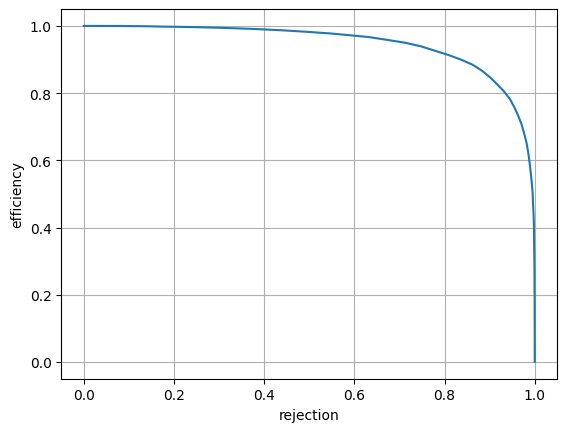

In [10]:
b, s, size = np.array([2., 1.5, 1., 0.5]), np.array([1., 2., 2., 1.]), 10000
# generators of n-poisson for b and b+s
h0, h1 = htcata.poisson_ncounter(b), htcata.poisson_ncounter(b + s)
# test of simple hypothesis - generate events and compute test-statistic
ht  = htcore.htsimple(h0, h1, size)
qrange = np.linspace(*ht.qrange(), 100)
rej = [1. - ht.p0value(qi) for qi in qrange]
eff = [1. - ht.p1value(qi) for qi in qrange]
plt.plot(rej, eff); plt.grid(True);
plt.xlabel('rejection'); plt.ylabel('efficiency');


## Discovery and rejection

We claim:

* **discovery** or **observation** of $H_1$ if the $H_0$ p-value ($\alpha$) is lower that $2.87 \times 10^{-7}$, which corresponds to $Z = 5$. 

Z-value is the p-value in terms of 'sigmas' of a Gaussian distribution!

* **evidence** of $H_1$ if the $H_0$ p-value ($\alpha$) is lower than $0.0027$, which is $Z=3$.

**This is a convention!** And statisticians like to discuss about it!

Note that *discovery* means that we *falsify* a hypothesis, $H_0$


**Example** Consider the gaussians in the next cell, move the alternative to $\mu = 5$ and generate some events for $H_1$ true. Have you discovered $H_1$? 

**Question** What is the fraction of the events for which you could claim discovery? (depends on $\beta$ value for which $\alpha$ provides 5$\sigma$)

observed data : 5
H0 p-value    : 0.00000029
H1 p-value    : 0.50000000
CLs           : 0.50000014 


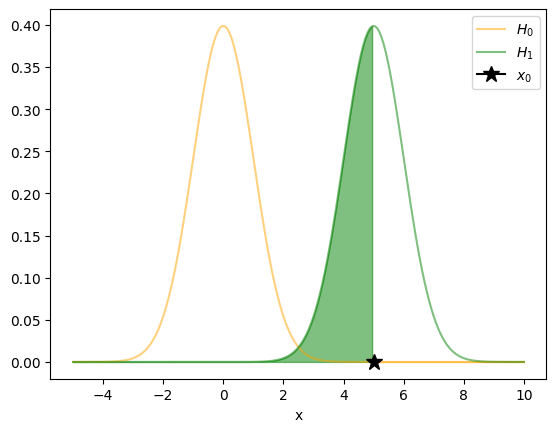

In [11]:
mu0, mu, mutrue = 0, 5., True
httoys.gaussian(mu0, mu, x0=5);

- For x=5, one could claim discovery (since H0 is excluded at 5$\sigma$). $\beta$ in this case is 0.5, so we could claim a discovery 50% of the times

We set:

* an **exclusion** limit on $H_1$ at a $\beta$ (i.e. 90%) confidence level, CL, if $H_1$ p-value, is $\le 1-\beta$.

This is: the probability to get an event with lower compatibility with $H_1$ than the observed event is smaller than 10% (for 90 % CL).

**Example**: In the case of the gaussians, do $\mu_1 = 2.5$ and generate events if $H_1$ is false.
    Can you exclude $H_1$ at 90% CL? In what fraction of the events you will exclude $H_1$?

observed data : 1.218
H0 p-value    : 0.11161199
H1 p-value    : 0.09992132
CLs           : 0.11247487 


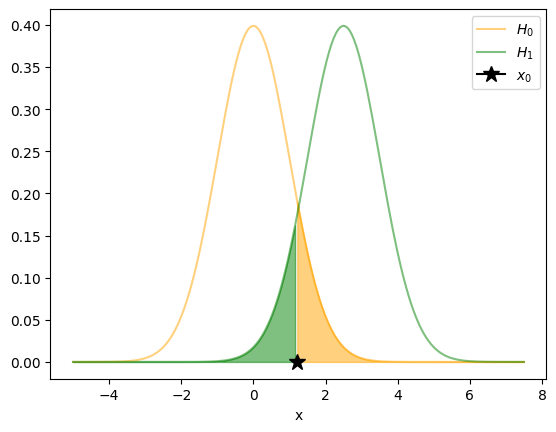

In [12]:
mu0, mu, mutrue = 0, 2.5, False
httoys.gaussian(mu0, mu, x0=1.218);

The x for which $\beta$=0.1 is x=1.218. The $1-\alpha$ corresponding to 1.218 is 0.888. This means in 88.8% of the cases we can reject $H_1$ at 90% CL


We define:

* the **reach** or **sensitivity** of an experiment as the expected exclusion of $H_1$, $\beta$, for the median of the $g(q | H_0)$ pdf.

That is, in case there is no signal, and we observe data in the median of the $H_0$ distribution, the reach is the limit we impose on $H_1$, its p-value.

* the **discovery potential** of an experiment is the $H_0$ p-value for the median of the $g(q | H_1)$ pdf.

That is, in case $H_1$ is true, and we observe data in the median of the $H_1$ distribution. The potential is the p-value of $H_0$ (the falseability!).

**Example** Consider the gaussian again, with $\mu = 5, \sigma = 2.5$, in the next cells we compute the sensitivity and the discovery potencial for this case.

observed data : 0
H0 p-value    : 0.50000000
H1 p-value    : 0.02275013
CLs           : 0.04550026 


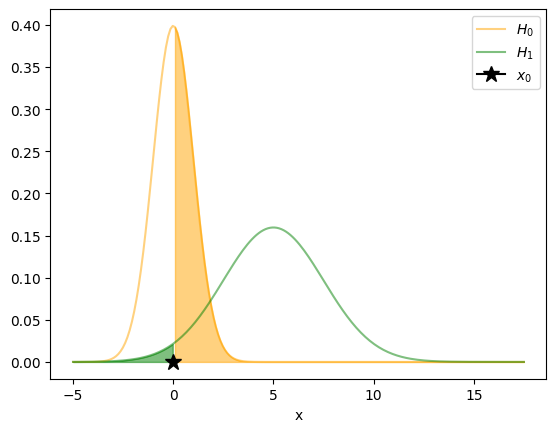

In [13]:
mu0, mu, sigma1, mutrue = 0, 5., 2.5, False
httoys.gaussian(mu0, mu, x0=0, sigma1 = sigma1);

In this case the reach would be given by $\beta$ at x=0, which provides the median of $H_0$. This is 0.02275
How about the discovery potential?

observed data : 5.0
H0 p-value    : 0.00000029
H1 p-value    : 0.50000000
CLs           : 0.50000014 


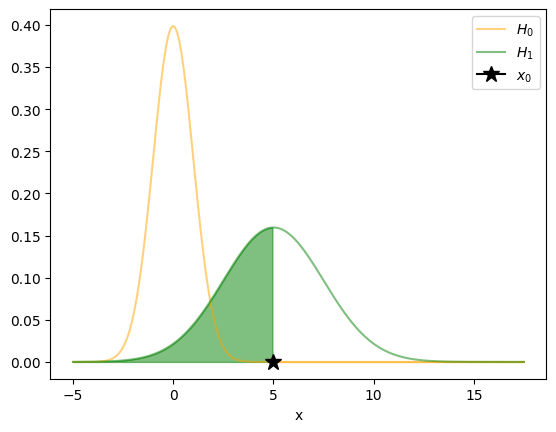

In [14]:
mu0, mu, sigma1, mutrue = 0, 5., 2.5, True
httoys.gaussian(mu0, mu, x0 = mu, mutrue = mutrue, sigma1 = sigma1);

**Exercise:** An experiment expects $(2, 1)$ background events in two bins, and a possible signal $(8, 9)$ on top. It observes $(9, 9)$, can claim observation?

**Exercise:** In case it observes $(1, 1)$, can reject the signal at 95 % CL?

**Exercise:** Consider an experiment with several independent channels that expects as background ${\bf b} = (2, 1.5, 1, 0.5) $ and as signal ${\bf s} = (1, 3, 3, 1)$. It finally measures $(2, 1, 1, 0)$. Compute the p-value of $H_1$. 

**Exercise:** Consider the above case of KamLAND-Zen, compute the p-value of $H_0$!

## The CLs method

In some cases the $H_1$ hypothesis is 'weak' compared with $H_0$ and the distributions of the test statistics $g(q \, | H_0)$ and $g(q \, | \,H_1) $ overlap. 

**Example**: Consider $H_0$ as a poisson of $b$ expected events, $b=4$, and the signal $s=0.5$ events. 

**Question**: If we measure $n \, = \,1$, the p-value for $H_1$ is $0.061$, below 10%. Do we exclude the signal at 90% CL? 

observed data : 1
H0 p-value    : 0.98168436
H1 p-value    : 0.06109948
CLs           : 0.66718373 


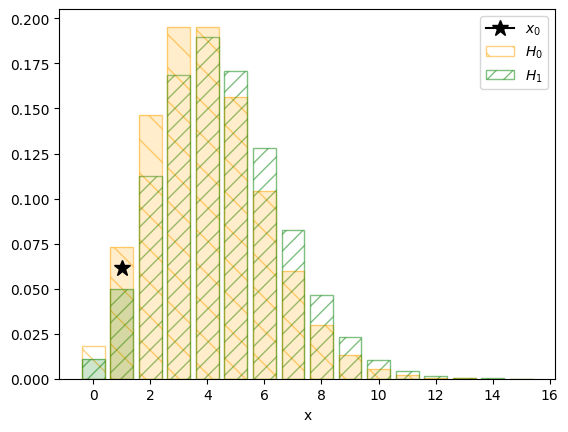

In [15]:
b, s, x0 = 4, 0.5, 1
httoys.poisson(b, b + s, x0); 

The pdfs of the test statistics, $g(q | H_0), \, g(q | H_1)$, for $b=4, \, s+b=4.5$ mostly overlap! 

In principle we reject $H_1$ at 90% CL. But the probability to accept $H_0$ is very small, $1-\alpha$! 

It may be more prudent to not reject $H_1$ and conclude that *the experiment has no enough reach*.

test statistics q-value 1 -0.7644339286872333
test statistics p-value 1 0.0595


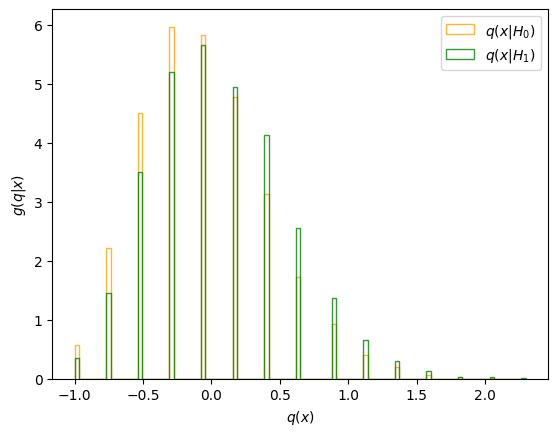

In [16]:
h0, h1, size = stats.poisson(4), stats.poisson(4.5), 10000
ht = htcore.htsimple(h0, h1, size)
htplot.plt_htsimple(ht);
print("test statistics q-value 1",ht.q(1))
print("test statistics p-value 1",ht.p1value(ht.q(1)))


The [CLs method](https://arxiv.org/abs/hep-ex/9902006) was developed to prevent these cases.


Instead of using the $H_1$ p-value, $\beta$, to reject $H_1$, it uses the value:

$$
CL_s \equiv \frac{CL_{s+b}}{CL_b} = \frac{\beta}{1-\alpha}
$$

That is, a ratio of fractions. Given an observation, the fraction of possible equal or worse events if we consider the $H_1$ hypothesis, with respect the fraction of possible equal or better events if we do the same with $H_0$.

Notice that $CLs$ is conservative, $CLs \ge \beta$. And that $1-\alpha \ge \beta$, the probability to accept $H_0$ is always greater than to reject $H_1$.

In [17]:
ns = range(12)
qs = ht.q(ns)
betas  = [ht.p1value(qi) for qi in qs]
clss   = [ht.cls    (qi) for qi in qs] 
clline = 0.1*np.ones(len(ns))

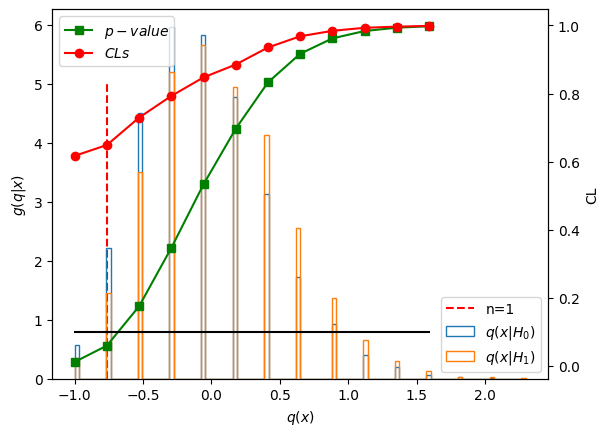

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel("$q(x)$")
ax.set_ylabel("$g(q|x)$")
ax.vlines(x=qs[1], ymin=0, ymax=5, colors='r', linestyles='dashed', label="n=1")
ax.hist(ht.q0s, bins = 100, density = True, range = ht.qrange(), histtype ='step', label = '$q(x|H_0)$')
ax.hist(ht.q1s, bins = 100, density = True, range = ht.qrange(), histtype ='step', label = '$q(x|H_1)$')
axb = ax.twinx()
axb.plot(qs, betas , marker='s', color = 'green', label = '$p-value$');
axb.plot(qs, clss  , marker='o', color = 'red', label = '$CLs$');
axb.plot(qs, clline, color = 'black');
axb.set_ylabel('CL');
axb.legend(); ax.legend(loc = 4);

In the previous example, the $H_1$ p-value was 0.06, but CLs value is 0.66! Therefore, we do not exclude $H_1$. 

The CLs has prevented us from doing an exclusion when the experiment has not enough sensitivity!

In case $H_1$ is well separated to $H_0$ a cut on $CL_s$ is equivalent to a cut on $\beta$.

The CLs method has been criticized as conservative, but has been and is frequenly used in HEP.

## Nuisance parameters 

Sometimes the pdf depends not only on $\mu$, but also on other parameters, $\nu$ of no "physical interest". There are called **nuisance parameters**.

The pdf $g(x \, | \, \mu, \nu)$, were $\mu$ is the parameter of interest, and $\nu$ the nuisance parameter. 


In some cases, we can marginalize the nuisance parameters. One possibility is use [the Cousins-Highland method](http://www.sciencedirect.com/science/article/pii/0168900292907945) also known as a bayesian-frequentist hybrid method.

If we know the pdf of the nuisance parameter: $\pi(\nu)$, we can marginalize its effect:

$$
g(x \, | \, \mu) = \int g( x \, | \, \mu, \nu) \, \pi(\nu) \, \mathrm{d}\nu
$$

It is common to take $\pi(\nu)$ as a gaussian with mean $\hat{\nu}$ and sigma $\sigma_\nu$.

Notice that this method is a hybrid: frequentist-bayesian.

## Intro to composite hypothesis

Often the $H_1$ hypothesis is not complete, it depends on several parameters.  

A typical example if searching for a new signal with an unkown cross-section or half-lifetime. We condense the unknown into a parameter, $\mu$, that quantifies the strength of the signal.

$H_1$ depends now on $\mu$. When $\mu=0$, we recover the case $H_0$.



We have a continuous set of hypothesis. This is know as **composite hypothesis testing**. How do we proceed? 

We can scan along $\mu$ and repeat the hypothesis test. But this can be *computationally expensive.*

In some cases there are simpler solutions, but first we need to go back to the concept of **Confidence Intervals**.

As we shall see composite hypothesis testing and confidence intervals are in fact connected!